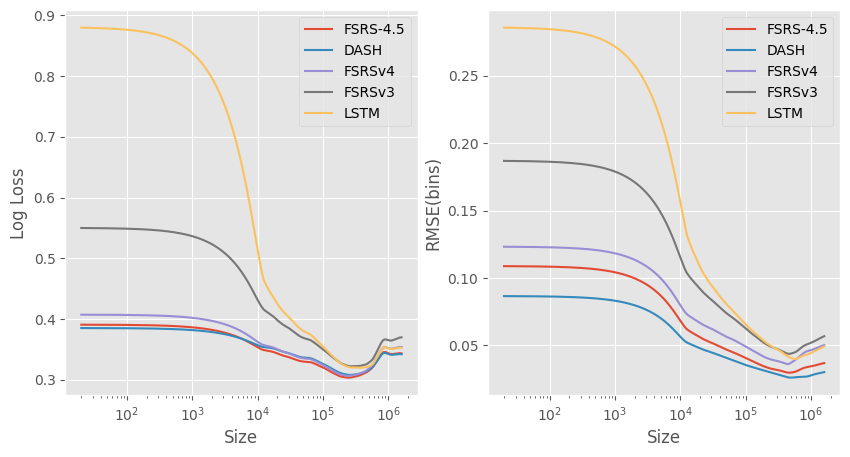

In [1]:
import json
import pathlib
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.style.use("ggplot")

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for model in ["FSRS-4.5", "DASH", "FSRSv4", "FSRSv3", "LSTM"]:
    metrics = []
    sizes = []
    users = []
    RMSE_list = []
    LogLoss_list = []
    result_dir = pathlib.Path(f"../result/{model}")
    result_files = result_dir.glob("*.json")
    for result_file in result_files:
        with open(result_file, "r") as f:
            result = json.load(f)
            sizes.append(result["size"])
            users.append(result["user"])
            metrics.append(result["metrics"])
            RMSE_list.append(result["metrics"]["RMSE(bins)"])
            LogLoss_list.append(result["metrics"]["LogLoss"])

    log_loss, size = zip(*sorted(zip(LogLoss_list, sizes), key=lambda x: x[1]))
    log_loss = lowess(
        log_loss, size, it=0, is_sorted=True, return_sorted=False
    )
    ax1.plot(size, log_loss, label=model)
    rmse_bins, size = zip(*sorted(zip(RMSE_list, sizes), key=lambda x: x[1]))
    rmse_bins = lowess(
        rmse_bins, size, it=0, is_sorted=True, return_sorted=False
    )
    
    ax2.plot(size, rmse_bins, label=model)

ax1.semilogx()
ax2.semilogx()
ax1.legend()
ax2.legend()
ax1.set_xlabel("Size")
ax1.set_ylabel("Log Loss")
ax2.set_xlabel("Size")
ax2.set_ylabel("RMSE(bins)")
plt.show()